In [5]:
import numpy, astropy
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import urllib
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import requests
from PIL import Image

This notebook takes an ALFALFA grid file, makes a quick moment zero map, downloads a DECaLS image for the corresponding sky area, and finally overlays HI contours on the image.

**Note**: You will need to have already downloaded the grid you wish to use and placed it in the same directory as this notebook. You can find instructions for accessing the grids in the [grid_access.md](../docs/grid_access.md) file in the docs folder. In this case you need the 1044+13 grid and the "a" spectral cube needs to be placed in the current working directory.

In [6]:
#Define the grid you are using
grid_ra = '1044'
grid_dec = '13'
freq_slice = 'a'

grid_filename = f'{grid_ra}+{grid_dec}{freq_slice}_spectral.fits'

#Open the grid
hdu = fits.open(grid_filename)

In [7]:
#Extract the data from fits file and average together the two polarizations
cube = numpy.mean(hdu[0].data,axis=0)

RMS noise = 2.198251724243164 mJy/beam


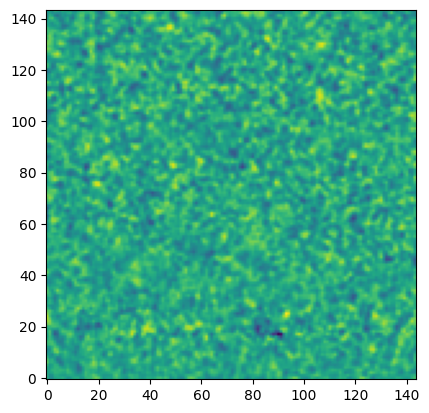

In [8]:
#Identify a line-free channel that is mostly just noise to estimate the rms from
chan = 300

#Calculate the rms
rms = numpy.sqrt(numpy.mean(numpy.square(cube[chan].flatten())))
print(f'RMS noise = {rms} mJy/beam')

#Plot the channel to make sure it doesn't contain sources
plt.imshow(cube[chan],origin='lower')

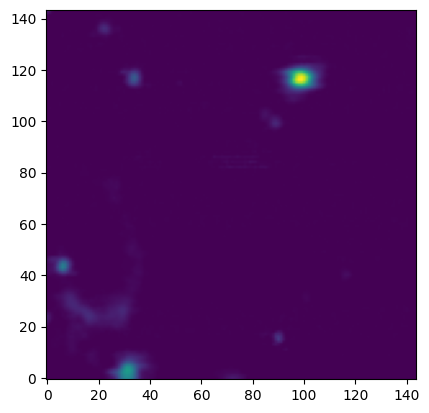

In [9]:
#Make a simple moment zero map over a select channel range
min_chan = 0
max_chan = 550

#Blank regions of the cube below 3 x rms
blanked_cube = numpy.where(cube[min_chan:max_chan] > 3*rms, cube[min_chan:max_chan], 0.)

#Sum the blanked cube to make the moment zero map
mom0 = numpy.sum(blanked_cube, axis = 0)

#Quickly plot the moment map
plt.imshow(mom0,origin='lower')

In [10]:
#Create a world coordinate system object for the moment map from the grid header
mom0_wcs = WCS(hdu[0].header,naxis=2)
#Note: The "naxis=2" means that only the first two axes (RA and Dec) will be used
#The frequency/velocity axis and the Stokes axis will both be ignored

print(mom0_wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---CAR' 'DEC--CAR' 
CRVAL : 162.2315687471258 11.8 
CRPIX : 0.0 0.0 
NAXIS : 144  144  1024  2


<br>
<br>

To give the moment zero map more physical units we should also multiply it by the width of a channel. This could be done simply in frequency to give units of Jy Hz / beam, but we will instead make the units Jy km/s / beam.

In [11]:
#Start by extracting the channel width from the header and build frequency array
chan_df = hdu[0].header['CDELT3']
freq = hdu[0].header['CRVAL3'] + hdu[0].header['CDELT3']*numpy.arange(0,1024,1)

#Now build velocity array
rest_freq = hdu[0].header['RESTFREQ']/1E6
vel = (astropy.constants.c.value/1000)*(rest_freq-freq)/freq

#Finally take the average channel width over the range used for the moment map
#Technically you should do this channel by channel, but this is close enough
chan_dv = numpy.mean(vel[min_chan:max_chan-1]-vel[min_chan+1:max_chan])
print(f'Channel width = {chan_dv} km/s')

Channel width = 5.216931816590015 km/s


In [12]:
#Now multiply the moment zero map by the channel width and divide by 1000 to get Jy.km/s
mom0_Jykms = mom0*chan_dv/1000

<br>

Now we need to decide on the dimensions that we want for our DECaLS image, build a WCS for it, and download the image. Then we need to reproject the moment zero map to the same dimensions as the DECaLS image and overlay them.

In [13]:
#Set the image size in pixels
n_pix = 1024

#Sets image size and pixel scale
x_wid, y_wid = n_pix, n_pix
pixscale = hdu[0].header['CDELT2']*144/n_pix

#Sets the coordinates of image center
center_ra = (numpy.floor(float(grid_ra)/100) + (float(grid_ra)-numpy.floor(float(grid_ra)/100)*100)/60)*15
center_dec = grid_dec
center_pos = SkyCoord(center_ra,center_dec,unit='deg')

In [14]:
#Sets the DECaLS URL to pull both the fits and jpeg image from
fits_url = 'https://www.legacysurvey.org/viewer/cutout.fits?ra={}&dec={}&layer=ls-dr10&pixscale={}&width={}&height={}&bands=g'.format(center_pos.ra.deg, center_pos.dec.deg, pixscale*3600., x_wid, y_wid)
fits_head = fits.getheader(fits_url)
DECaLS_url = f"https://www.legacysurvey.org/viewer/cutout.jpg?ra={center_pos.ra.deg}&dec={center_pos.dec.deg}&layer=ls-dr10&pixscale={pixscale*3600.}&width={x_wid}&height={y_wid}"

#Get WCS for image
DECaLS_projection = WCS(fits_head)

#Downloads and saves jpeg image
urllib.request.urlretrieve(DECaLS_url, f'{grid_ra}+{grid_dec}_DECaLS.jpeg')

('1044+13_DECaLS.jpeg', <http.client.HTTPMessage at 0x128779d10>)

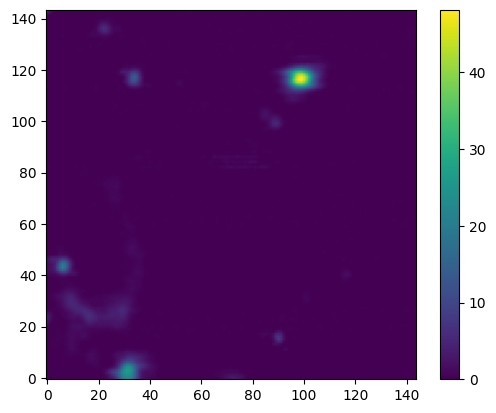

In [15]:
plt.imshow(mom0_Jykms,origin='lower')
plt.colorbar()

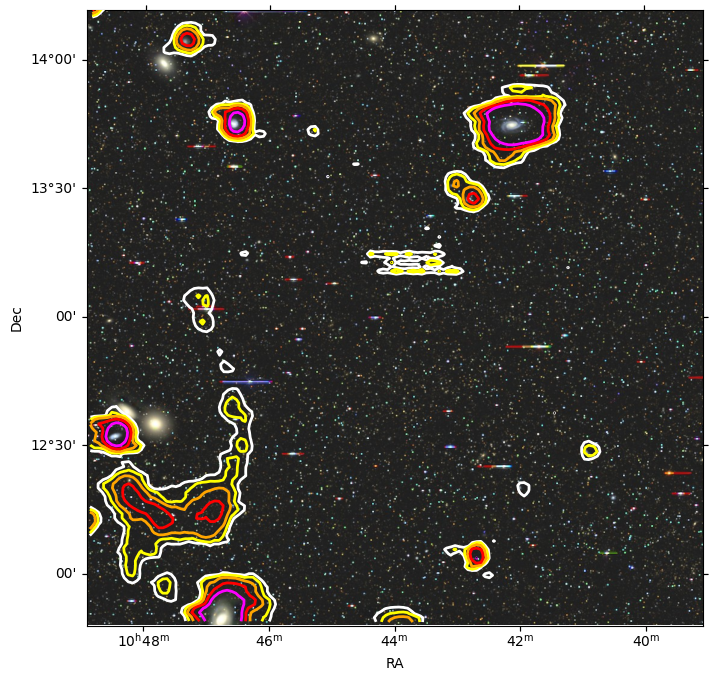

In [16]:
#Finally make the overlay

#Open the DECaLS jpeg that we downloaded
DECaLS_jpeg = Image.open(f'{grid_ra}+{grid_dec}_DECaLS.jpeg')

#Set the contour levels
min_contour = 0.5 #Jy km/s / beam
contour_levels = min_contour*numpy.array([1,2,4,8,16])

#Make the plot
plt.figure(figsize=[8,8])
ax = plt.subplot(111,projection=DECaLS_projection)
ax.imshow(DECaLS_jpeg)
ax.contour(mom0_Jykms,colors=['w','yellow','orange','r','magenta'],levels=contour_levels,linewidths=2,transform=ax.get_transform(mom0_wcs))
plt.xlabel('RA')
plt.ylabel('Dec')